In [1]:
import torch
torch.set_default_dtype(torch.float64)
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving HW4_testX.csv to HW4_testX.csv
Saving HW4_testY.csv to HW4_testY.csv
Saving HW4_trainX.csv to HW4_trainX.csv
Saving HW4_trainY.csv to HW4_trainY.csv


In [4]:
X_ = pd.read_csv('HW4_trainX.csv', header=None)
Y_ = pd.read_csv('HW4_trainY.csv', header=None)
Y_.columns = ['label']
XTe_ = pd.read_csv('HW4_testX.csv', header=None)
YTe_ = pd.read_csv('HW4_testY.csv', header=None)
YTe_.columns = ['label']
X = pd.concat([X_, Y_], axis=1)
X = X.sample(frac=1, random_state=2021).reset_index(drop=True) # shuffle order of train data
XTe = XTe_.values
YTe = YTe_.values

In [5]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,label
0,-8.877633,-4.988349,-0.802256,0.908694,-8.359831,3.125817,-7.635531,-4.909033,8.111748,9.697362,11.475873,-2.847601,-13.861445,1.686948,-1.268426,-3.896460,-0.382001,1.120097,10.759210,2.605240,-6.364507,-2.575549,3.039942,1.091288,-1.343694,0.454638,-5.532439,8.831789,-4.734574,-9.822811,5.245867,10.116462,-10.370415,-2.348511,-3.176725,-15.225733,7.665479,-10.196886,-10.163139,13.114764,...,19.592479,-2.174130,-2.332155,-9.597314,-0.155850,-3.606780,-0.191524,2.266344,-8.478748,4.056967,7.254199,3.085846,-13.377208,-1.414295,7.966882,-3.865442,-8.055877,4.255322,0.777745,-3.210500,-3.767357,-3.181233,-0.053500,10.626647,-8.388469,-0.866175,6.535171,6.264470,-9.332316,-11.296359,-0.655811,-10.712476,2.144959,5.925416,-2.138765,-0.998630,1.913525,8.215790,-4.023998,0.0
1,1.820210,8.527890,3.108450,-2.107363,3.273998,-0.975619,2.333665,-1.461596,15.569036,-5.246080,-1.301872,0.615807,3.090773,7.156054,4.848258,-4.619223,-4.583586,-10.745978,-9.524176,-3.252834,5.794012,-7.454532,-4.277712,6.803315,3.527690,5.235603,5.960931,3.579312,2.325858,5.912739,-3.268772,-4.520102,3.258076,3.675429,7.050910,-2.166955,4.820076,4.778818,-3.347077,-1.385810,...,-4.624363,1.381832,-13.450052,1.976994,7.056607,3.446479,-11.689699,-2.011140,-2.715702,-2.186473,7.361720,13.069647,-8.787991,4.883706,-7.662886,10.197177,-6.922589,-13.496525,-1.169379,4.198209,-5.430226,-3.858002,-8.947999,-1.264553,-7.993036,-9.974971,-1.232860,-6.041534,5.438701,0.890773,2.945386,-2.450873,-2.583260,2.494414,2.244806,0.513524,-6.196141,0.976750,5.371389,1.0
2,-6.505170,4.213002,0.320114,-1.516173,8.798776,2.520488,-9.600837,-4.585410,8.043876,9.006640,6.611845,3.739438,-2.152995,3.194317,-0.135239,-3.734964,9.172095,7.367968,-5.283488,1.108323,-0.648752,-5.741590,-11.380347,3.203910,10.142405,-12.114650,-5.214868,-4.538065,-10.344210,-10.389575,-2.182895,10.421494,-3.281695,-2.467131,0.322510,-13.120791,-4.023442,-6.824313,7.940306,-0.057075,...,3.892966,7.608348,-4.901829,3.551240,4.735203,-2.581995,-8.463299,6.404824,-1.812524,-5.913494,-2.227329,-1.092153,3.750167,-2.240419,-18.189944,-3.694973,5.473732,4.909670,-9.762619,2.473283,5.509808,-4.998094,-2.636971,3.420118,-11.549450,-10.742494,-3.170787,0.941096,-2.000503,-10.931463,-3.754194,-5.533352,4.500409,-7.376810,-0.098817,-2.829375,10.115780,-1.936930,0.333444,0.0
3,-3.057462,-0.667760,-6.789097,5.738642,-2.451594,-6.302276,1.981742,0.762735,-6.428582,0.481005,4.055625,0.262119,5.085068,-8.296791,0.057504,-2.435673,10.524198,-1.015114,-7.314051,-4.866136,-9.182147,-6.247429,0.973891,1.656997,13.556483,12.387438,1.728528,4.319002,0.946410,-5.579232,4.198673,2.298296,1.868099,-10.273919,-1.718553,-0.655959,-9.348687,-3.626984,-9.043277,2.794711,...,-1.453594,6.819781,-2.123432,-8.223461,1.480936,2.465037,-2.103665,-3.087451,-1.321608,-3.827335,-1.881443,9.648790,-3.564744,4.315808,6.021663,-2.726455,2.660582,2.301409,-9.073973,-7.154202,0.256995,-2.614138,-6.883990,-4.452873,1.227197,-0.781620,-7.651591,-1.609754,4.433253,2.785853,3.214723,9.943795,-0.991320,14.989951,3.243697,1.076221,4.348711,6.645039,-1.925012,0.0
4,6.078838,-0.338871,5.584812,4.587661,-3.954789,0.881276,-1.491145,-1.474869,-2.162800,-2.463698,-4.725970,-0.375449,0.633154,18.501823,-3.610761,-0.494745,0.998308,-3.729431,6.257722,-1.425695,12.522275,8.810036,-2.491097,-6.351963,-15.047331,5.184380,5.122366,-0.192085,-3.339662,0.875348,0.561479,-1.214216,-3.779242,3.401218,-5.844367,-5.278109,0.801784,7.237664,8.139613,-1.719706,...,-8.218273,-2.460593,6.265711,-5.606913,-3.798867,-0.909234,10.528229,2.701007,-6.482347,1.609666,11.850628,-6.389033,3.403576,-4.282411,0.100135,-8.197810,-3.918961,-2.324833,6.678784,6.259109,-6.659462,-6.580141,10.565783,13.352935,-2.122785,4.284295,-3.317004,-5.249553,-5.5

In [21]:
if torch.cuda.is_available():
  device = 'cuda:0'
else:
  device = 'cpu'

In [23]:
device

'cuda:0'

In [14]:
class MyDataset(torch.utils.data.dataset.Dataset):
  def __init__(self, df):
    self.df = df
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    features = self.df.iloc[idx, :-1].values
    outcomes = np.array(self.df.iloc[idx,-1])
    return {"features":features, "outcomes":outcomes}

In [175]:
# Hyperparameters
valid_size = 0.2
learning_rate = 5e-2
epochs = 200
batch_size = 64
wd = 1e-5

In [252]:
split = int(np.floor(valid_size * len(X))) # Split train and valid
train_dataset = MyDataset(X[:-split])
valid_dataset = MyDataset(X[-split:])

In [253]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                           shuffle=True)

In [254]:
def initialization(m):
  if type(m) == torch.nn.Linear:
    torch.nn.init.xavier_normal_(m.weight)
    m.bias.data.fill_(0.01)

In [261]:
# Model
input_dim = 100
model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 8),
    torch.nn.BatchNorm1d(8),
    torch.nn.GELU(),
    torch.nn.Linear(8, 16),
    torch.nn.GELU(),
    torch.nn.Linear(16, 1),
    torch.nn.Sigmoid(),
)
model.apply(initialization)
model = model.to(device)
params = list(model.parameters())
print("The number of parameters:", sum([p.numel() for p in model.parameters() if p.requires_grad]), "elements")

The number of parameters: 985 elements


In [262]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)
loss_list = [] # avg loss for total epoch
best_acc = None
early_stop_counter = 0
epoch = 0 # save last epoch
# Train
for epoch in range(epochs):
  running_loss = [] # loss for one epoch
  model.train()
  for i, batch in enumerate(train_loader):
    x = batch['features'].to(device)
    y = batch['outcomes'].view(-1,1).to(device)
    # Forward pass: Compute predicted y by passing x to the model     
    y_pred = model(x)

    # Compute and print loss
    loss = loss_fn(y_pred, y)
    running_loss.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  # Save Training loss of each epoch
  avg_loss = sum(running_loss) / len(running_loss)
  print("epoch: {} loss: {:.3f}".format(epoch+1, avg_loss), end=" ")
  loss_list.append(avg_loss)


  # Validation
  model.eval()
  with torch.no_grad():
    valid_accuracy = [] # loss of validation set
    for data in valid_loader:
      valid_x = data["features"].to(device)
      valid_y = data["outcomes"].view(-1,1)
      valid_y_pred = model(valid_x).to("cpu").detach().numpy()
      valid_y_pred = [1.0 if x > 0.5 else 0.0 for x in valid_y_pred]           
      valid_accuracy.append(f1_score(valid_y, valid_y_pred, average='weighted'))

    # Save minimum validation loss model
    val_acc = sum(valid_accuracy) / len(valid_accuracy)
    print("validation accuracy: {:.3f}".format(val_acc))    
    if not best_acc or val_acc > best_acc:
      torch.save(model.state_dict(), './best.pt')
      best_acc = val_acc
      early_stop_counter = 0
    else: # No evolution
      early_stop_counter += 1
      scheduler.step()
  if early_stop_counter == 30: # early stop
    break

epoch: 1 loss: 0.589 validation accuracy: 0.713
epoch: 2 loss: 0.533 validation accuracy: 0.756
epoch: 3 loss: 0.505 validation accuracy: 0.754
epoch: 4 loss: 0.491 validation accuracy: 0.762
epoch: 5 loss: 0.482 validation accuracy: 0.766
epoch: 6 loss: 0.478 validation accuracy: 0.778
epoch: 7 loss: 0.478 validation accuracy: 0.768
epoch: 8 loss: 0.478 validation accuracy: 0.761
epoch: 9 loss: 0.470 validation accuracy: 0.775
epoch: 10 loss: 0.469 validation accuracy: 0.770
epoch: 11 loss: 0.469 validation accuracy: 0.766
epoch: 12 loss: 0.466 validation accuracy: 0.774
epoch: 13 loss: 0.460 validation accuracy: 0.784
epoch: 14 loss: 0.459 validation accuracy: 0.775
epoch: 15 loss: 0.461 validation accuracy: 0.773
epoch: 16 loss: 0.460 validation accuracy: 0.774
epoch: 17 loss: 0.459 validation accuracy: 0.779
epoch: 18 loss: 0.456 validation accuracy: 0.775
epoch: 19 loss: 0.457 validation accuracy: 0.782
epoch: 20 loss: 0.455 validation accuracy: 0.785
epoch: 21 loss: 0.456 validat

In [263]:
learning_rate

0.05

In [264]:
scheduler.get_last_lr()

[0.024741932980010352]

Weighted F1: 0.7973565890482698


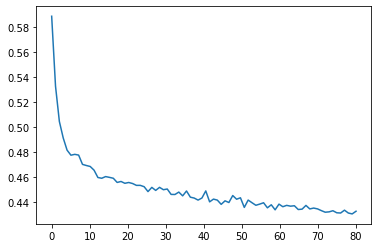

In [265]:
# Test
model.load_state_dict(torch.load('./best.pt'))
model = model.to("cpu")
y_pred = model(torch.from_numpy(XTe))
yp = y_pred.detach().numpy()
yp = [1.0 if x > 0.5 else 0.0 for x in yp]

print("Weighted F1:", f1_score(YTe, yp, average='weighted'))

step = np.linspace(0, epoch+1, epoch+1)
plt.plot(step, np.array(loss_list))